# ICE 2: Natural Language Processing
### Nikita Tejwani
### HUDK 4051: Learning Analytics

In [1]:
#Import necessary packages
import pandas as pd
import numpy as np
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from gensim import matutils, models
import scipy.sparse
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('ICE2_data_eval.csv')

#data wrangling
#the category of the evaluation is made into its own column
#the scores and comments for each category are concatenated into only two columns
evals_teaching = pd.DataFrame()
evals_teaching = pd.concat([evals_teaching, df.iloc[:,0:2]], axis = 1)
evals_teaching['category'] = 'teaching'
evals_teaching.rename(columns = {'teaching':'score', 'teaching.1':'comments'}, inplace = True)

evals_content = pd.DataFrame()
evals_content = pd.concat([evals_content, df.iloc[:,2:4]], axis = 1)
evals_content['category'] = 'content'
evals_content.rename(columns = {'coursecontent':'score', 'coursecontent.1':'comments'}, inplace = True)

evals_exams = pd.DataFrame()
evals_exams = pd.concat([evals_exams, df.iloc[:,4:6]], axis = 1)
evals_exams['category'] = 'exams'
evals_exams.rename(columns = {'examination':'score', 'Examination':'comments'}, inplace = True)

evals_lab = pd.DataFrame()
evals_lab = pd.concat([evals_lab, df.iloc[:,6:8]], axis = 1)
evals_lab['category'] = 'lab'
evals_lab.rename(columns = {'labwork':'score', 'labwork.1':'comments'}, inplace = True)

evals_library = pd.DataFrame()
evals_library = pd.concat([evals_library, df.iloc[:,8:10]], axis = 1)
evals_library['category'] = 'library'
evals_library.rename(columns = {'library_facilities':'score', evals_library.columns[1]:'comments'}, inplace = True)

evals_extracurricular = pd.DataFrame()
evals_extracurricular = pd.concat([evals_extracurricular, df.iloc[:,10:12]], axis = 1)
evals_extracurricular['category'] = 'extracurricular'
evals_extracurricular.rename(columns = {'extracurricular':'score', 'extracurricular.1':'comments'}, inplace = True)

In [3]:
#concatenate all the dataframes containing evals for each category
evals = pd.concat([evals_teaching, evals_content, evals_exams, evals_lab, evals_library, evals_extracurricular], axis = 0)

,score,comments,category
0,0,teacher are punctual but they should also give...,teaching
1,1,Good,teaching
2,1,Excellent lectures are delivered by teachers a...,teaching
3,1,Good,teaching
4,1,teachers give us all the information required ...,teaching
...,...,...,...
180,1,they all are held in super,extracurricular
181,1,good,extracurricular
182,1,the extracurricular activities held in univers...,extracurricular
183,1,Our university has lot of extracurricular goin...,extracurricular


In [4]:
#define a function that will clean the text of the comments
def clean_text(text):
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('[0-9]+', '', text)
    return text

#use the new function to clean the comments
evals.comments = evals.comments.apply(lambda x:clean_text(x))

In [5]:
#Count vectorizer finds the count of each word and creates a document-term matrix
cv = CountVectorizer(stop_words = 'english')
comment_cv = cv.fit_transform(evals.comments)
dtm = pd.DataFrame(comment_cv.toarray(), columns = cv.get_feature_names())
dtm.index = evals.comments.index
dtm

,abilities,ability,able,abroad,absolutely,absurd,abt,academic,accessable,accitivties,...,works,world,worth,write,writing,wrong,yeah,year,years,yes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
182,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
183,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#exploratory analysis
evals.groupby(['score', 'category']).count().unstack()
#comments are overwhelmingly positive
word_counts = dtm.sum()
dtm[word_counts.sort_values(ascending = False).index[:30]].sum()

good           654
excellent       74
students        62
university      61
library         48
books           47
course          43
pattern         40
teachers        39
lab             39
activities      37
knowledge       36
time            32
teaching        31
content         31
work            30
paper           30
checking        30
courses         29
average         29
exam            29
practical       27
marks           27
facilities      26
delivery        26
interaction     25
material        24
like            23
depth           23
lecture         22
dtype: int64

In [7]:
#transpose the matrix, then form a dictionary of the locations of each term in the matrix
tdm = dtm.transpose()
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)
id2word = dict((v,p) for p,v in cv.vocabulary_.items())

#LDA: statistical model which uses word distribution to abstract topics
lda = models.LdaModel(corpus = corpus, id2word = id2word, num_topics = 3, passes = 50)
lda.print_topics()

[(0,
  '0.293*"good" + 0.033*"excellent" + 0.028*"students" + 0.018*"lab" + 0.014*"work" + 0.014*"teachers" + 0.013*"average" + 0.013*"practical" + 0.012*"university" + 0.012*"delivery"'),
 (1,
  '0.033*"library" + 0.030*"course" + 0.027*"books" + 0.022*"content" + 0.020*"courses" + 0.018*"activities" + 0.018*"university" + 0.018*"facilities" + 0.017*"material" + 0.016*"depth"'),
 (2,
  '0.031*"pattern" + 0.024*"paper" + 0.024*"checking" + 0.023*"exam" + 0.021*"marks" + 0.020*"good" + 0.017*"examination" + 0.016*"time" + 0.014*"faculty" + 0.013*"distribution"')]

In [8]:
#Text classification using Naive Bayes

#test train split
x = evals['comments']
y = evals['score']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)


#Prepare the training features
features = cv.fit_transform(x_train)

#Plug data into the naive bayes model
nb = MultinomialNB()
nb.fit(features, y_train)

#Print model accuracy
print(nb.score(cv.transform(x_test), y_test))

0.7747747747747747


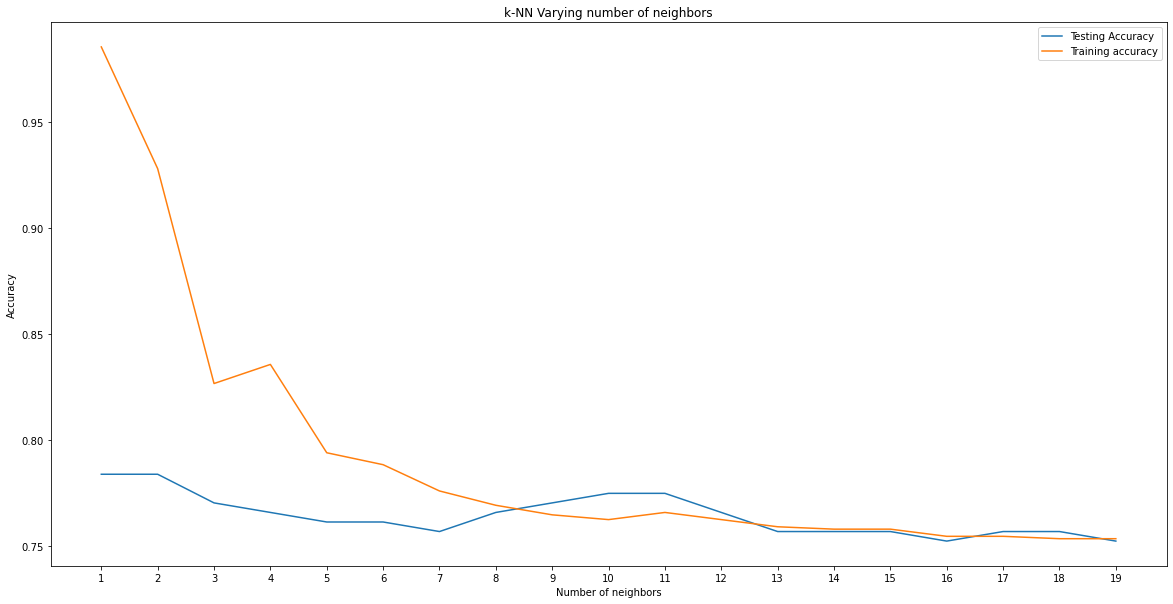

In [9]:
#Text classification using K Nearest neighbors
neighbors = np.arange(1, 20)
test_accuracy = np.empty(len(neighbors))
train_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(features, y_train)
    test_accuracy[i] = knn.score(cv.transform(x_test), y_test)
    train_accuracy[i] = knn.score(cv.transform(x_train), y_train)
    
plt.figure(figsize = (20,10))
plt.xticks(np.arange(1, 20, step = 1))
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

#Best number of neighbors appears to be 13, as this model results in good testing accuracy without overfitting

Both models of text classification have almost 80% accuracy in determining the score provided given the comments.  This model couild potentially be used to test hypotheses regarding the reliability of evaluation scores.